#### IMPORTS

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### FUNCIONES

Función para descargar el dataset CIFAR-10 y adaptarlo a ResNet18 <br>
(en caso de tenerlo ya descargado no hace ningún cambio)

In [3]:
def cargar_datos_test(imagen_size=224, batch_size=32):

    # Transformaciones para adaptar las imágenes de CIFAR-10 al formato esperado por ResNet
    transform = transforms.Compose([
        transforms.Resize(imagen_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Carga el conjunto de pruebas de CIFAR-10 (o lo descarga si no está disponible localmente)
    testset = torchvision.datasets.CIFAR10(
        root="./CIFAR-10-Python/data",
        train=False, download=True,
        transform=transform
    )

    # Crea un DataLoader para cargar los datos por lotes durante el test
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    return testloader

Función para evaluar el modelo y mostrar matriz de confusión

In [4]:
def evaluar_modelo(testloader, descripcion=""):
    
    # Contadores de muestras observadas y aciertos
    correct = 0
    total = 0 

    # Listas para almacenar las predicciones y etiquetas verdaderas
    all_preds = []
    all_labels = []

    start = time.time()

    # Desactiva el cálculo de gradientes para mejorar el rendimiento (solo se hace test)
    with torch.no_grad():
        for data in testloader:

            # Carga de imágenes y etiquetas y paso a GPU
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Paso por el modelo y selección de la clase más probable
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, 1)

            # Incremento del número de muestras y de aciertos (según la predicción)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardado de los resultados para la matriz de confusión
            # Usando CPU para evitar interferencias con la GPU
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end = time.time()

    # Cálculo de la precisión
    accuracy = 100 * correct / total

    # Muestra de resultados
    print(f"--- {descripcion} ---")
    print(f"Precisión: {accuracy:.2f}%")
    print(f"Tiempo de inferencia: {end - start:.2f} segundos")

    # Cálculo y muestra la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Matriz de Confusión - {descripcion}")
    plt.tight_layout()
    plt.show()
    print()

#### MODELO RESNET18

Clases de CIFAR-10

In [5]:
CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

Indicación de uso exclusivo de GPU y carga del modelo ResNet18 preentrenado

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise RuntimeError("No hay GPU disponible")
print("Dispositivo:", device)
print("CUDA:",torch.version.cuda)


model = resnet18()

#  10 salidas el para CIFAR-10 (en lugar de 1000 como en el modelo original)
model.fc = nn.Linear(model.fc.in_features, 10)  
model = model.to(device)
model.eval()  # No se realiza trabajo de train, solo test

print() # Para evitar el output generado por la carga del modelo

Dispositivo: cuda
CUDA: 12.8



#### TESTS

Test 1: Resolución original de ResNet18 (224x224), batch_size 32

100%|██████████| 170M/170M [00:15<00:00, 11.0MB/s] 


--- Test 1 - Resolución 224x224, batch 32 ---
Precisión: 9.17%
Tiempo de inferencia: 15.42 segundos


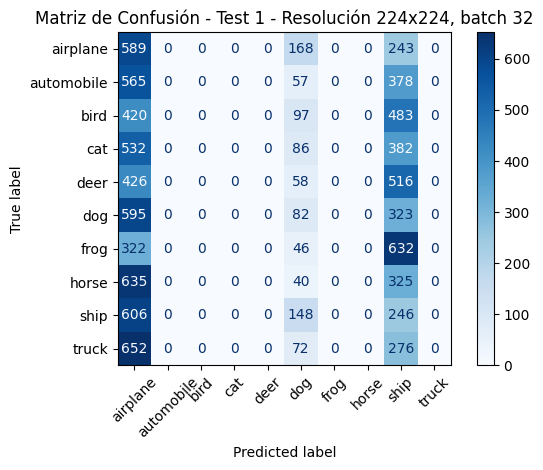

In [13]:
testloader_1 = cargar_datos_test(imagen_size=224, batch_size=32)
evaluar_modelo(testloader_1, "Test 1 - Resolución 224x224, batch 32")

Test 2: Mayor resolución (256x256), batch_size 16

--- Test 2 - Resolución 256x256, batch 16 ---
Precisión: 8.82%
Tiempo de inferencia: 18.78 segundos


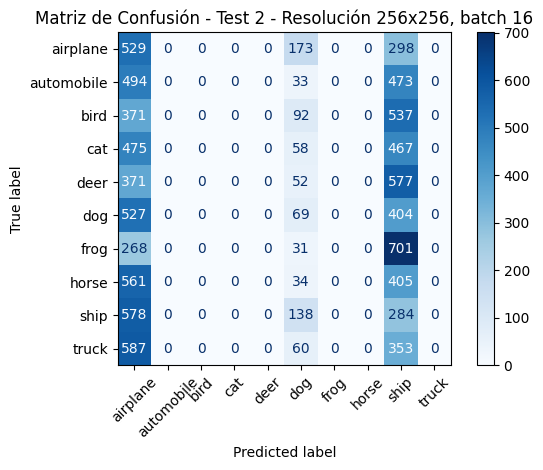

In [14]:
testloader_2 = cargar_datos_test(imagen_size=256, batch_size=16)
evaluar_modelo(testloader_2, "Test 2 - Resolución 256x256, batch 16")

Test 3: Resolución más baja (112x112), batch_size 64

--- Test 3 - Resolución 112x112, batch 64 ---
Precisión: 9.99%
Tiempo de inferencia: 6.52 segundos


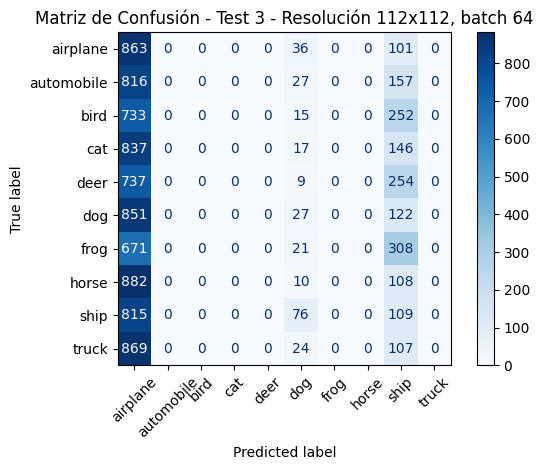

In [15]:
testloader_3 = cargar_datos_test(imagen_size=112, batch_size=64)
evaluar_modelo(testloader_3, "Test 3 - Resolución 112x112, batch 64")

Test 4: Muy alta resolución (384x384), batch_size 8

--- Test 4 - Resolución 384x384, batch 8 ---
Precisión: 8.24%
Tiempo de inferencia: 38.76 segundos


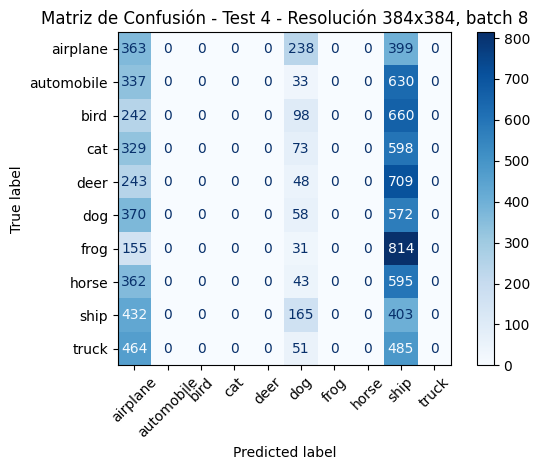

In [16]:
testloader_4 = cargar_datos_test(imagen_size=384, batch_size=8)
evaluar_modelo(testloader_4, "Test 4 - Resolución 384x384, batch 8")

Test 5: Resolución 224x224, batch_size 1 (modo real-time)

--- Test 5 - Resolución 224x224, batch 1 ---
Precisión: 9.17%
Tiempo de inferencia: 55.85 segundos


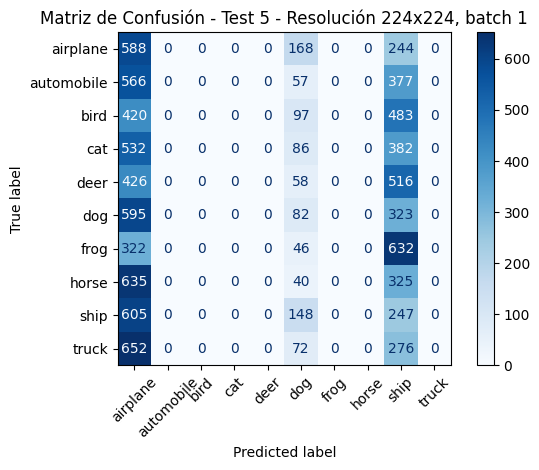

In [17]:
testloader_5 = cargar_datos_test(imagen_size=224, batch_size=1)
evaluar_modelo(testloader_5, "Test 5 - Resolución 224x224, batch 1")